# Loading CSV Data

Quick walkthrough of loading OHLCV data from CSV files using the `CSVProvider` and `DataHandler`.

In [ ]:
import sandtable as st

## CSVProvider

Point it at a directory containing CSV files. It resolves filenames automatically - 
looks for `{SYMBOL}_{start}_{end}.csv` first, then falls back to `{SYMBOL}.csv`.

In [2]:
provider = st.CSVProvider("../data/fixtures")

df = provider.fetch("SPY", "2020-01-01", "2023-12-31")
df.head()

[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.data_providers: Loading SPY from ../data/fixtures/SPY_2018-01-01_2023-12-31.csv
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.data_providers: Loaded 1006 bars for SPY from SPY_2018-01-01_2023-12-31.csv


,open,high,low,close,volume
date,,,,,
2020-01-02,296.480163,297.717259,295.554627,297.698914,59151200
2020-01-03,294.299278,296.571870,294.244299,295.444733,77709700
2020-01-06,293.685302,296.654338,293.566170,296.571869,55653900
2020-01-07,296.003671,296.480198,295.288909,295.737946,40496400
2020-01-08,295.930430,298.532899,295.683022,297.314148,68296000


In [3]:
print(f"Shape: {df.shape}")
print(f"Date range: {df.index[0]} to {df.index[-1]}")
print(f"Columns: {list(df.columns)}")

Shape: (1006, 5)
Date range: 2020-01-02 00:00:00 to 2023-12-29 00:00:00
Columns: ['open', 'high', 'low', 'close', 'volume']


In [4]:
df.describe()

,open,high,low,close,volume
count,1006.000000,1006.000000,1006.000000,1006.000000,1.006000e+03
mean,374.664369,377.148802,372.051213,374.752460,8.772824e+07
std,53.448642,53.115266,53.723071,53.457628,4.321520e+07
min,210.334563,211.707964,201.181559,205.504578,2.645790e+07
25%,345.213387,347.923003,342.334234,344.462791,6.209985e+07
50%,387.016888,389.808782,384.784435,387.696915,7.759675e+07
75%,416.047379,418.640484,414.305468,416.386848,9.963225e+07
max,465.375391,466.029210,464.770353,465.189972,3.922207e+08


<Axes: title={'center': 'SPY Close 2020-2023'}, xlabel='date'>

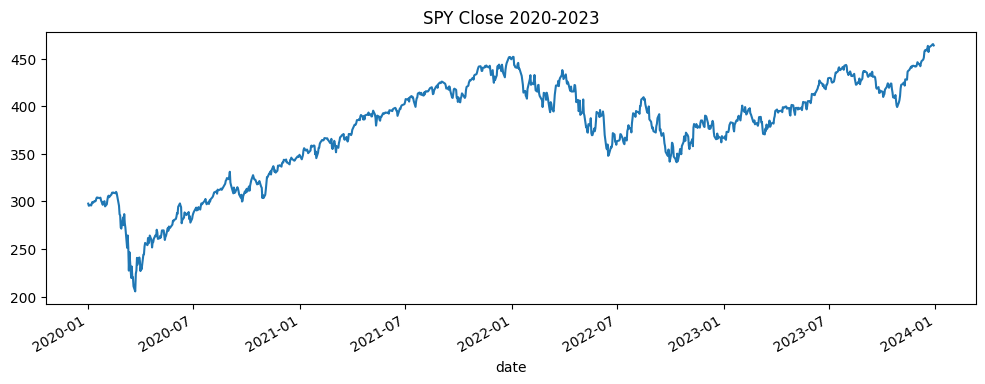

In [ ]:
df["close"].plot(figsize=(12, 4), title="SPY close 2020-2023")

## `DataHandler`

Wraps a provider and handles multi-symbol loading + iteration. This is what you pass into `run_backtest`.

In [6]:
data = st.DataHandler(
    provider=provider,
    universe=["SPY", "AAPL", "MSFT"]
)
data.load("2020-01-01", "2023-12-31")

print(f"Symbols: {data.universe}")
print(f"Total bars: {len(data)}")

[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.handler: Loading data for SPY (2020-01-01 to 2023-12-31)
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.data_providers: Loading SPY from ../data/fixtures/SPY_2018-01-01_2023-12-31.csv
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.data_providers: Loaded 1006 bars for SPY from SPY_2018-01-01_2023-12-31.csv
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.handler: Loaded 1006 bars for SPY
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.handler: Loading data for AAPL (2020-01-01 to 2023-12-31)
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.data_providers: Loading AAPL from ../data/fixtures/AAPL_2018-01-01_2023-12-31.csv
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.data_providers: Loaded 1006 bars for AAPL from AAPL_2018-01-01_2023-12-31.csv
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.handler: Loaded 1006 bars for AAPL
[2026-02-22 18:00:24] DEBUG:sandtable.data_engine.handler: Loading data for MSFT (2020-01-01 to 2023

Symbols: Universe(symbols=['SPY', 'AAPL', 'MSFT'])
Total bars: 3018


You can grab the raw dataframe back out with `get_price_data()`:

In [7]:
prices = data.get_price_data()

for sym, df in prices.items():
    print(f"{sym}: {len(df)} rows, {df.index[0].date()} to {df.index[-1].date()}")

SPY: 1006 rows, 2020-01-02 to 2023-12-29
AAPL: 1006 rows, 2020-01-02 to 2023-12-29
MSFT: 1006 rows, 2020-01-02 to 2023-12-29


## Iterating as events

Under the hood, the backtest engine pulls `MarketDataEvent` objects one at a time. You can do this manually too:

In [ ]:
data.reset()

events = list(data.iter_events())
print(f"Total events: {len(events)}\n")

# first few
for e in events[:5]:
    print(
        f"{e.timestamp.date()} | {e.symbol} | O={e.open:.2f} H={e.high:.2f} "
        f"L={e.low:.2f} C={e.close:.2f} V={e.volume:,.0f}"
    )

Events are interleaved chronologically across symbols, so on each date you'll get one event per symbol.

In [ ]:
# quick check of events per symbol
from collections import Counter

counts = Counter(e.symbol for e in events)
counts

Counter({'SPY': 1006, 'AAPL': 1006, 'MSFT': 1006})